In [1]:
import numpy as np
import pyemma.msm as msm
import msmtools.generation as msmgen
import pyemma.coordinates as coor
import matplotlib.pylab as plt
%matplotlib inline


/anaconda3/envs/py35/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.5, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


## Helper functions

In [2]:
def get_obs_dtraj(obs_traj):
    n_obs_states = int(np.sqrt(obs_traj.shape[0]))
    clustering = coor.cluster_kmeans(data=obs_traj, k=n_obs_states, max_iter=100)
    return clustering.dtrajs

In [3]:
def get_free_energy_traj(model):
    from sklearn.preprocessing import MinMaxScaler
    # Get stationary distribution and convert to Free Energy
    stat_dist = model.stationary_distribution_obs
    free_energy = -np.log(stat_dist)
    # Invert the scale
    free_energy = np.abs(np.max(free_energy)-free_energy)
    # Calculate free energy of each state
    traj = hmm.discrete_trajectories_obs[0]
    free_energy_traj = free_energy[traj]
    # Scale to between 0 - 1
    scaler = MinMaxScaler()
    free_energy_traj_scaled = scaler.fit_transform(free_energy_traj[:, np.newaxis])
    return free_energy_traj_scaled
    

In [11]:
def get_static_properties(model):
    # Get free energy, assignments and number of hidden states
    free_energy_scaled = get_free_energy_traj(model)
    membership = model.metastable_assignments
    n_sets = model.nstates
    # calculate free energy for observed states assigned to each hidden state
    free_energy_by_state = [free_energy_scaled[np.where(membership==i)[0]] for i in range(n_sets)]
    
    # Calculate the 'volume' of each hidden state
    volume_by_state = [np.sum(free_energy_scaled[np.where(membership==i)[0]]) for i in range(n_sets)]

    # Calculate the other properties
    properties = {}
    properties['max'] = [np.max(x) for x in free_energy_by_state]
    properties['min'] = [np.min(x) for x in free_energy_by_state]
    properties['volume'] = volume_by_state
    
    # scale the properties to their max values:
    scaled_properties = {}
    for k, v in properties.items():
        signs = np.sign(v)
        v = np.abs(v)
        scaled_v = np.array(v)/np.max(v)
        scaled_v = scaled_v*signs
        scaled_properties[k] = list(scaled_v)
    
    return scaled_properties

In [5]:
def get_entropy_traj(model):
    from scipy.stats import entropy
    p_traj = model.hidden_state_probabilities[0]
    entropy_traj = entropy(p_traj.T)
    return entropy_traj

## Generate two state data

In [6]:
P = np.array([[0.99, 0.01],
              [0.01, 0.99]])
T = 50000
means = [np.array([-1,1]), np.array([1,-1])]
widths = [np.array([0.3,2]),np.array([0.3,2])]

In [7]:

# continuous trajectory
X = np.zeros((T, 2))
# hidden trajectory
dtraj = msmgen.generate_traj(P, T)
for t in range(T):
    s = dtraj[t]
    X[t,0] = widths[s][0] * np.random.randn() + means[s][0]
    X[t,1] = widths[s][1] * np.random.randn() + means[s][1]    

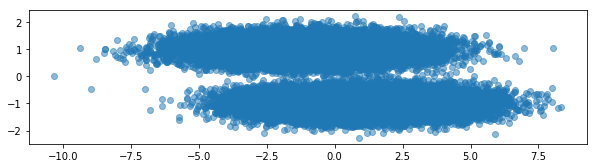

In [8]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(X[:,1], X[:,0], alpha=0.5)
axes.set_aspect('equal')


## Create HMM model 

In [9]:
dtraj = get_obs_dtraj(X)
hmm = msm.estimate_hidden_markov_model(dtraj,nstates=2, lag=1)

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2'), max=223), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

## Calculate model properties

In [12]:
hmm_traj = hmm.hidden_state_probabilities[0]
entropy_traj = get_entropy_traj(hmm)
free_energy_traj = get_free_energy_traj(hmm)
properties = get_static_properties(hmm)


In [14]:
import time
import argparse
import math
from pythonosc import osc_message_builder
from pythonosc import udp_client


# hmm_traj = hmm_traj[1:]
# entropy = entropy_traj[1:]
# free_energy_traj = free_energy_traj[1:]

Nsteps = hmm_traj.shape[0]

parser = argparse.ArgumentParser()
parser.add_argument("--ip", default="127.0.0.1",
                    help="")
parser.add_argument("--port", type=int, default=5005,
                    help="")
args = parser.parse_args()

client = udp_client.SimpleUDPClient(args.ip, args.port)

for k, v in properties.items():
    for i, x in enumerate(v):
        client.send_message("/properties/{0}/state{1}".format(k,i), float(x))

for i in range(Nsteps):

    for j in range(hmm_traj.shape[1]):
        client.send_message("/state{}".format(j+1), float(hmm_traj[i][j]))

    client.send_message("/free_energy", float(free_energy_traj[i]))

    client.send_message("/entropy", float(entropy[i]))

    time.sleep(.05)

usage: ipykernel_launcher.py [-h] [--ip IP] [--port PORT]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/robertarbon/Library/Jupyter/runtime/kernel-ccff25c4-55fc-41de-9f15-9ed123df2fff.json


SystemExit: 2

/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
